# Import Package, and Func.

In [74]:
from pyscf import gto, scf, fci
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.providers.fake_provider import GenericBackendV2

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, AerProvider
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# runtime imports


# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum", token ='55ac54cb4cbfe378d8604606bacfcab38ffd165ecdb215742e64495a259fa53f0ed9e63df5b3df4489d422865a007d9cc981fcb2caffd9e76f17d94d734a8593')
#backend = service.least_busy(operational=True, simulator=False)
#backend = GenericBackendV2(num_qubits=4,noise_info=False)
backend = AerSimulator(method = "statevector",noise_model=None)

## FCI

In [75]:
def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'H 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

    # 4. 결과 출력
    #print(f"Hartree–Fock Energy: {hf_energy:.10f} Hartree")
    #print(f"FCI Ground State Energy: {fci_energy:.10f} Hartree")

In [76]:
'''
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B

from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.primitives import Estimator

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
'''


'\nfrom qiskit_nature.second_q.transformers import ActiveSpaceTransformer\nfrom qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver\nfrom qiskit_nature import settings\nfrom qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B\n\nfrom qiskit.circuit.library import TwoLocal\nfrom qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE\nfrom qiskit.primitives import Estimator\n\nfrom qiskit_ibm_runtime import Session\nfrom qiskit_ibm_runtime.fake_provider import FakeManilaV2\nfrom qiskit_ibm_runtime import QiskitRuntimeService\nfrom qiskit_ibm_runtime import EstimatorV2 as Estimator\n'

In [77]:
def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy

In [78]:
def VQE(dist):
    atoms = ["H", "H"]
    basis = 'sto3g'
    coords = [(0,0,0), (dist,0,0)]
    charge = 0
    multiplicity = 1
    Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
    driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
    E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 
    fermionic_hamiltonian = E_problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
    hamiltonian, mapper = fermion_to_qubit(E_problem, second_q_op, "JW", z2symmetry_reduction=None)
    num_particles = E_problem.num_particles
    num_spatial_orbitals = E_problem.num_spatial_orbitals

    init_state = HartreeFock(num_spatial_orbitals,num_particles,mapper)
    ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)
    target = backend.target
    pm = generate_preset_pass_manager(target=target)

    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout) # 그니까 컴파일 된거.

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)
    with Session(backend=backend) as session:
        estimator = Estimator(mode=session)
        estimator.options.default_shots = 10000

        res = minimize(
            cost_func,
            x0,
            args=(ansatz_isa, hamiltonian_isa, estimator),
            method="cobyla",
            options={"maxiter": 20000} ,
            tol = 10**(-6)
        )
    
    return res.fun + repulsion

## Cacl.

In [89]:
x = np.arange(0.3, 2.5, 0.08)
E_VQE = []
E_FCI = []
for dist in x:
    e_vqe = VQE(dist)
    e_fci = FCI(dist)
    while e_vqe - e_fci > 0.005:
        e_vqe = VQE(dist)

    E_VQE.append(e_vqe)
    E_FCI.append(e_fci)


converged SCF energy = -0.593827758535727
converged SCF energy = -0.860658533375386
converged SCF energy = -1.00050673843552
converged SCF energy = -1.07310309277679
converged SCF energy = -1.10693036699135
converged SCF energy = -1.11734903499028
converged SCF energy = -1.11338782445513
converged SCF energy = -1.10055080623256
converged SCF energy = -1.08220447580839
converged SCF energy = -1.06042300594045
converged SCF energy = -1.03653887502918
converged SCF energy = -1.0114736465476
converged SCF energy = -0.985910345399061
converged SCF energy = -0.960372494913136
converged SCF energy = -0.935260492617247
converged SCF energy = -0.910873554594386
converged SCF energy = -0.887427960052492
converged SCF energy = -0.865073515627711
converged SCF energy = -0.843907591197448
converged SCF energy = -0.823986264782553
converged SCF energy = -0.805332844893278
converged SCF energy = -0.787944468139426
converged SCF energy = -0.771797500520221
converged SCF energy = -0.756852260585157
con

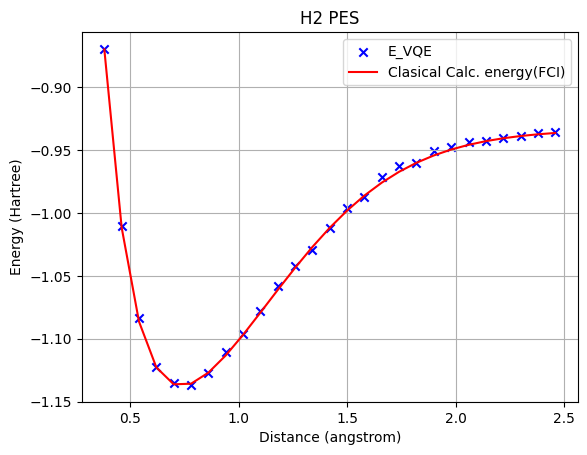

In [102]:
plt.scatter(x[1:], E_VQE[1:], marker='x',color='blue', label="E_VQE")
plt.plot(x[1:], E_FCI[1:], color='red', label="Clasical Calc. energy(FCI)")

plt.xlabel("Distance (angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.title("H2 PES")
plt.grid()
plt.show()

/var/folders/ym/2mkphtxj6yl3s830m3rpnw8c0000gn/T/ipykernel_5117/1218118593.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


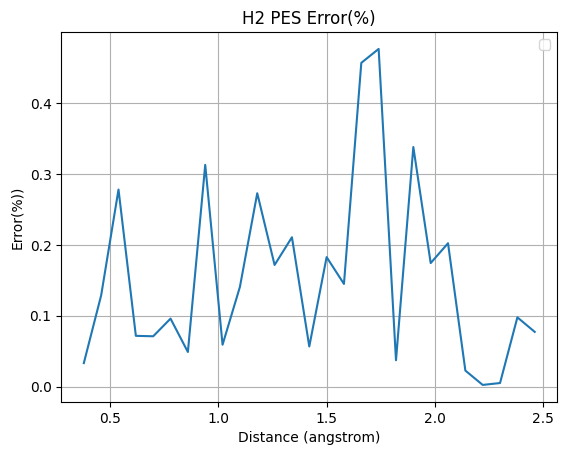

In [101]:
err= []
for i in range(len(x)):
    error = 100*np.abs(E_FCI[i] - E_VQE[i])
    err.append(error)

plt.plot(x[1:], err[1:])

plt.xlabel("Distance (angstrom)")
plt.ylabel("Error(%))")
plt.legend()
plt.title("H2 PES Error(%)")
plt.grid()
plt.show()